# Data visualisation et analyse de cohortes e-commerce 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

###  1. Fusionner les tables à analyser

Pour cette analyse, nous n'aurons besoin que de 2 variables : les IDs des vendeurs dans `olist_sellers_dataset` et la date de chaque vente (`order_purchase_timestamp`) dans `olist_orders_dataset`. 

**Fusionner les tables et ne conserver que les 2 colonnes pertinentes.**

_Indice : pour connecter les deux tables, il est indispensable d'utiliser `olist_order_items_dataset` comme intermédiaire (avec `order_id`)._

In [2]:
df_orders = pd.read_csv('https://raw.githubusercontent.com/dujiaying/olist/master/data/olist_orders_dataset.csv')
df_order_items = pd.read_csv('https://raw.githubusercontent.com/dujiaying/olist/master/data/olist_order_items_dataset.csv')
df_sellers = pd.read_csv('https://raw.githubusercontent.com/dujiaying/olist/master/data/olist_sellers_dataset.csv')

In [3]:
# Méthode avec pd.merge
df = pd.merge(df_orders, df_order_items, on='order_id')
df = pd.merge(df, df_sellers, on='seller_id')
df = df[['seller_id', 'order_purchase_timestamp']]
df.head(3)

,seller_id,order_purchase_timestamp
0,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33
1,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-10 13:35:55
2,3504c0cb71d7fa48d967e0e4c94d59d9,2017-07-12 14:11:58


In [4]:
# Méthode avec df.merge
df = df_orders.merge(df_order_items, on='order_id').merge(df_sellers, on='seller_id')
df = df[['seller_id', 'order_purchase_timestamp']]
df

,seller_id,order_purchase_timestamp
0,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33
1,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-10 13:35:55
2,3504c0cb71d7fa48d967e0e4c94d59d9,2017-07-12 14:11:58
3,3504c0cb71d7fa48d967e0e4c94d59d9,2017-07-24 22:16:25
4,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-19 14:06:58
...,...,...
112645,babcc0ab201e4c60188427cae51a5b8b,2018-07-01 10:23:10
112646,8501d82f68d23148b6d78bb7c4a42037,2017-03-11 19:51:36
112647,d263fa444c1504a75cbca5cc465f592a,2018-07-24 09:46:27
112648,edf3fabebcc20f7463cc9c53da932ea8,2018-05-22 21:13:21


###  2. Convertir la colonne de dates au bon type, et conserver uniquement les données de Jan 2017 à Sept 2018.

_Indice :  il est possible (mais optionnel) d'utiliser les méthodes `df.assign()` et `df.query()`. `df.assign()` permet de créer une nouvelle colonne à partir d'une fonction lambda. `df.query()` permet de filtrer un dataframe selon la date. Ces méthodes sont "bonus", elles permettent d'être plus concis mais ne sont pas du tout obligatoires._

In [5]:
# Méthode "classique"
df['date'] = pd.to_datetime(df['order_purchase_timestamp'])
df = df.drop('order_purchase_timestamp', axis=1)
df = df[ (df['date'] >= '2017') & (df['date'] <= '09-2018') ]
df

,seller_id,date
0,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33
1,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-10 13:35:55
2,3504c0cb71d7fa48d967e0e4c94d59d9,2017-07-12 14:11:58
3,3504c0cb71d7fa48d967e0e4c94d59d9,2017-07-24 22:16:25
4,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-19 14:06:58
...,...,...
112645,babcc0ab201e4c60188427cae51a5b8b,2018-07-01 10:23:10
112646,8501d82f68d23148b6d78bb7c4a42037,2017-03-11 19:51:36
112647,d263fa444c1504a75cbca5cc465f592a,2018-07-24 09:46:27
112648,edf3fabebcc20f7463cc9c53da932ea8,2018-05-22 21:13:21


In [6]:
# Méthode "élégante" (mais peut-être un peu moins claire à la lecture..!)
df = (df
     .assign(date = lambda x: pd.to_datetime(x['date']))
     .query('date >= "2017-01-01" & date < "2018-09-01"') # Only data from 2017 onwards and before 2018-09
     )
df.head(3)

,seller_id,date
0,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33
1,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-10 13:35:55
2,3504c0cb71d7fa48d967e0e4c94d59d9,2017-07-12 14:11:58


### 3. Constituer les cohortes selon le mois de première vente (1 cohorte par mois)

Pour créer les cohortes, commencer par extraire le mois de vente à partir des dates complètes. 

Ensuite, ordonner les données selon le mois de vente et supprimer les doublons dans la colonne `seller_id` (afin de ne conserver que la première apparition de chaque vendeur).

_Hint: Pour extraire le mois, on peut utiliser la méthode `df['col'].dt.to_period('M')`._

In [7]:
# Méthode "classique"
seller_cohort = df.copy()

# tri et drop_duplicates pour conserver seulement la 1ère vente
seller_cohort = seller_cohort.sort_values(by='date')
seller_cohort = seller_cohort.drop_duplicates(subset='seller_id', keep='first')

# extraction du mois (nom de cohorte)
seller_cohort['cohort'] = seller_cohort['date'].dt.to_period('M')

# formatting final
seller_cohort = seller_cohort.reset_index(drop=True)
seller_cohort = seller_cohort.drop('date', axis=1)
seller_cohort

,seller_id,cohort
0,48efc9d94a9834137efd9ea76b065a38,2017-01
1,8f119a0aee85c0c8fc534629734e94fd,2017-01
2,b14db04aa7881970e83ffa9426897925,2017-01
3,46dc3b2cc0980fb8ec44634e21d2718e,2017-01
4,b2ba3715d723d245138f291a6fe42594,2017-01
...,...,...
3063,26e2e5033827d2ba53929f43e03d8ffe,2018-08
3064,b76f4d90e85657a240495c876313adc5,2018-08
3065,e8ff5a6ceb895583033fc2a0f314e3c2,2018-08
3066,3296662b1331dea51e744505065ae889,2018-08


In [8]:
# Méthode "élégante"
seller_cohort = (df
                 .assign(cohort = lambda x: x['date'].dt.to_period('M'))
                 .sort_values('date')
                 .drop_duplicates('seller_id')
                 .reset_index()
                 .loc[:, ['seller_id', 'cohort']]
                )
seller_cohort.head(3)

,seller_id,cohort
0,48efc9d94a9834137efd9ea76b065a38,2017-01
1,8f119a0aee85c0c8fc534629734e94fd,2017-01
2,b14db04aa7881970e83ffa9426897925,2017-01


###  4. Visualiser le nombre de vendeurs dans chaque cohorte grâce à un diagramme en bâtons

Avant de continuer l'analyse, nous allons visualiser nos données - en particulier, nous aimerions avoir une idée de la taille de chaque cohorte. Compter le nombre de vendeurs uniques dans chaque cohorte, puis utiliser seaborn pour créer un bar chart.

_Indice : souvenez-vous de la fonction `sns.catplot()` !_

In [9]:
size_cohorts = (seller_cohort
                .groupby('cohort')['seller_id']
                .nunique()
                .reset_index()
                )
size_cohorts

,cohort,seller_id
0,2017-01,227
1,2017-02,255
2,2017-03,176
3,2017-04,121
4,2017-05,126
5,2017-06,76
6,2017-07,117
7,2017-08,129
8,2017-09,128
9,2017-10,148


In [10]:
# Ou plus court :
size_cohorts = seller_cohort['cohort'].value_counts(sort=False).reset_index()
size_cohorts.columns = ['cohort', 'seller_id']
size_cohorts

,cohort,seller_id
0,2017-01,227
1,2017-02,255
2,2017-03,176
3,2017-04,121
4,2017-05,126
5,2017-06,76
6,2017-07,117
7,2017-08,129
8,2017-09,128
9,2017-10,148


/Users/oliverSec/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


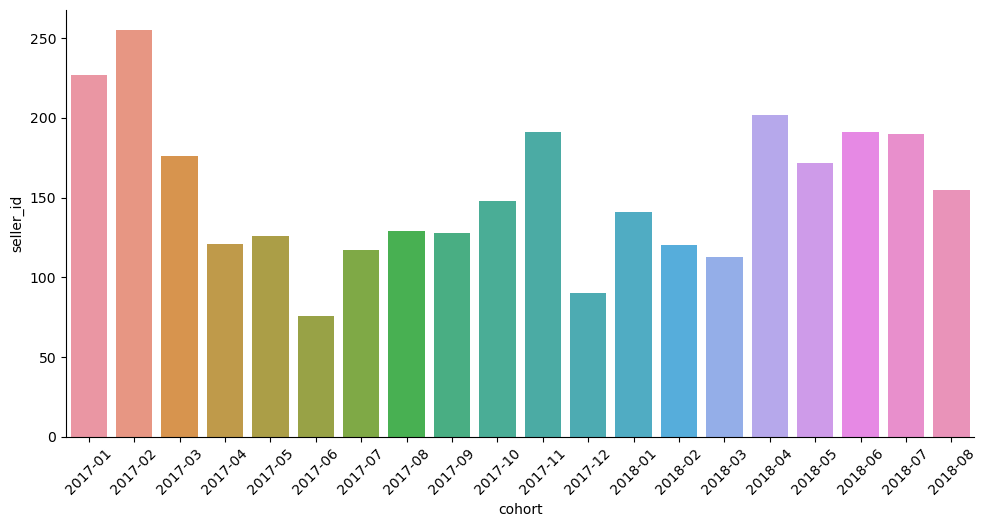

In [11]:
# Plot
sns.catplot(data=size_cohorts, x='cohort', y='seller_id', kind='bar', aspect=2)
plt.xticks(rotation=45);

/Users/oliverSec/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


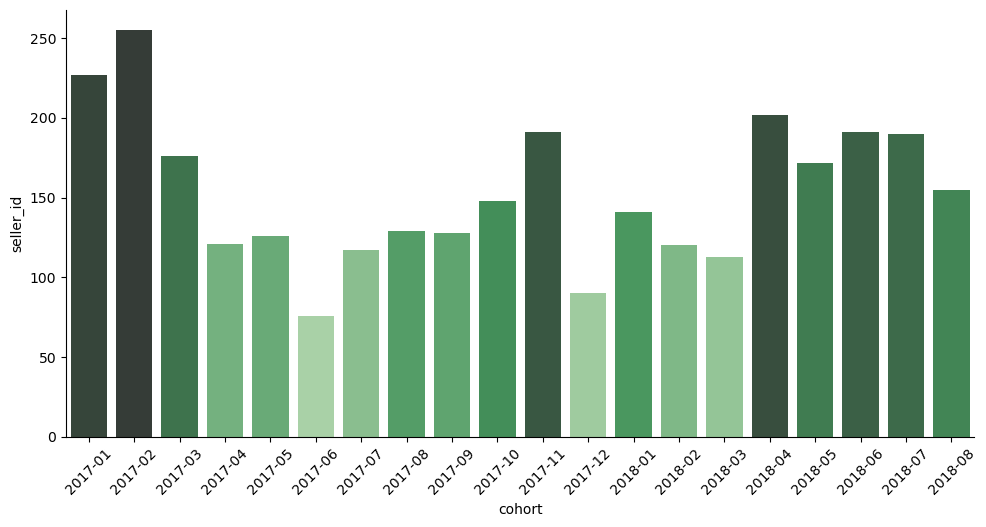

In [12]:
# Bonus: plot with custom color palette

colors = sns.color_palette("Greens_d", len(size_cohorts)) # create 1 color per cohort
rank = size_cohorts['seller_id'].argsort().argsort() # get the rank of each cohort
sns.catplot(data=size_cohorts, y='seller_id', x='cohort', 
            kind='bar', aspect=2, palette=np.array(colors)[rank])
plt.xticks(rotation=45);

On observe une certaine variabilité dans le nombre de nouveaux vendeurs par mois, mais aucun effet saisonnier ne semble évident. Etudions l'attrition de ces cohortes.

### 5. Pour chaque vendeur, calculer la différence entre chacune de ses ventes et sa cohorte (mois de première vente)

Fusionner la table contenant les noms de cohortes (question précédente) avec la table initiale (contenant toutes les ventes). 

Il est maintenant possible de calculer la différence (en mois) entre la date de chaque vente et la cohorte du vendeur (mois de première vente). Vous pourrez appeler cette différence `delta`.

In [13]:
# Méthode "classique"
cohort_df = pd.merge(df, seller_cohort, on='seller_id')
cohort_df['date'] = cohort_df['date'].dt.to_period('M')
cohort_df['delta'] = cohort_df['date'].astype(int) - cohort_df['cohort'].astype(int)
#cohort_df['delta'] = cohort_df['delta'].apply(lambda x: x.n) # autre méthode
cohort_df

,seller_id,date,cohort,delta
0,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10,2017-07,3
1,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08,2017-07,1
2,3504c0cb71d7fa48d967e0e4c94d59d9,2017-07,2017-07,0
3,3504c0cb71d7fa48d967e0e4c94d59d9,2017-07,2017-07,0
4,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08,2017-07,1
...,...,...,...,...
112274,babcc0ab201e4c60188427cae51a5b8b,2018-07,2018-07,0
112275,8501d82f68d23148b6d78bb7c4a42037,2017-03,2017-03,0
112276,d263fa444c1504a75cbca5cc465f592a,2018-07,2018-07,0
112277,edf3fabebcc20f7463cc9c53da932ea8,2018-05,2018-05,0


In [14]:
# Méthode "élégante" (mais pas forcément plus claire à la lecture..!)
cohort_df = (pd.merge(df, seller_cohort, on='seller_id')
             .assign(date_of_sale = lambda x: x.date.dt.to_period('M'),
                     delta = lambda x: (x.date_of_sale - x.cohort).apply(lambda x: x.n))
             .loc[:, ['seller_id', 'cohort', 'date_of_sale', 'delta']]
             )
cohort_df.head(3)

,seller_id,cohort,date_of_sale,delta
0,3504c0cb71d7fa48d967e0e4c94d59d9,2017-07,2017-10,3
1,3504c0cb71d7fa48d967e0e4c94d59d9,2017-07,2017-08,1
2,3504c0cb71d7fa48d967e0e4c94d59d9,2017-07,2017-07,0


###  6. Etude de l'attrition des vendeurs (churn)

Pour chaque cohorte, compter le nombre de vendeurs uniques par delta. 

Convertir ce nombre pour l'exprimer en pourcentage de la taille de la cohorte.

Ces calculs nous permettent d'observer quelle proportion de chaque cohorte continue de réaliser des ventes au fil du temps.

_Indices : il faudra d'abord grouper votre table par cohorte et par delta pour obtenir le nombre de vendeurs uniques par cohorte et par delta.
Ensuite, on pourra fusionner cette table avec les totaux calculés dans la question précédente, afin de calculer les pourcentages par rapport au total de chaque cohorte._

In [15]:
# Méthode "classique"

# compter le nb de vendeurs dans chaque cohorte et chaque delta
cohort_df_delta = cohort_df.groupby(['cohort', 'delta'])['seller_id'].nunique()
cohort_df_delta = cohort_df_delta.reset_index()
cohort_df_delta = cohort_df_delta.merge(size_cohorts, on='cohort')
cohort_df_delta.columns = ['cohort', 'delta', 'per_delta', 'total']
cohort_df_delta['proportion'] = (cohort_df_delta['per_delta'] / cohort_df_delta['total'])*100
cohort_df_delta = cohort_df_delta.drop(columns=['per_delta', 'total'])
cohort_df_delta

,cohort,delta,proportion
0,2017-01,0,100.000000
1,2017-01,1,75.770925
2,2017-01,2,73.568282
3,2017-01,3,63.436123
4,2017-01,4,66.079295
...,...,...,...
205,2018-06,1,56.020942
206,2018-06,2,59.685864
207,2018-07,0,100.000000
208,2018-07,1,56.315789


In [16]:
# Méthode "élégante" (mais pas forcément plus claire à la lecture..!)
cohort_df_delta = (cohort_df
                 .groupby(['cohort', 'delta'])[['seller_id']]
                 .nunique()
                 .assign(total = lambda x: x.groupby('cohort')['seller_id']
                                            .transform(lambda x: x[0]),
                         proportion = lambda x: 100 * x.seller_id / x.total)
                 .reset_index()
                 .loc[:, ['cohort', 'delta', 'proportion']]
                )

cohort_df_delta

,cohort,delta,proportion
0,2017-01,0,100.000000
1,2017-01,1,75.770925
2,2017-01,2,73.568282
3,2017-01,3,63.436123
4,2017-01,4,66.079295
...,...,...,...
205,2018-06,1,56.020942
206,2018-06,2,59.685864
207,2018-07,0,100.000000
208,2018-07,1,56.315789


### 7. Pivoter la table 

Utiliser  `df.pivot()` (ou `df.pivot_table`) pour obtenir une table avec les valeurs de delta en colonnes, les différentes cohortes en lignes et les proportions calculées comme valeurs.


In [17]:
cohort_pivot = cohort_df_delta.pivot(columns='delta', index='cohort', values='proportion')
cohort_pivot

delta,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cohort,,,,,,,,,,,,,,,,,,,,
2017-01,100.0,75.770925,73.568282,63.436123,66.079295,62.114537,55.947137,60.792952,55.506608,55.947137,54.625551,48.458150,50.660793,47.577093,48.458150,45.374449,38.766520,38.766520,35.682819,39.207048
2017-02,100.0,61.176471,54.509804,56.470588,45.098039,48.627451,47.450980,42.352941,41.960784,41.568627,41.960784,36.862745,35.686275,35.294118,37.254902,29.411765,30.980392,28.627451,25.882353,NaN
2017-03,100.0,57.954545,54.545455,49.431818,46.022727,48.295455,44.886364,40.909091,48.295455,36.931818,39.772727,32.954545,34.090909,30.681818,29.545455,29.545455,26.136364,27.840909,NaN,NaN
2017-04,100.0,55.371901,47.107438,51.239669,49.586777,44.628099,38.016529,47.107438,39.669421,38.842975,32.231405,33.884298,32.231405,30.578512,25.619835,28.925620,23.140496,NaN,NaN,NaN
2017-05,100.0,50.000000,50.000000,51.587302,46.825397,42.857143,43.650794,37.301587,39.682540,40.476190,35.714286,31.746032,27.777778,23.809524,27.777778,20.634921,NaN,NaN,NaN,NaN
2017-06,100.0,42.105263,40.789474,47.368421,31.578947,38.157895,36.842105,32.894737,27.631579,28.947368,27.631579,26.315789,21.052632,22.368421,21.052632,NaN,NaN,NaN,NaN,NaN
2017-07,100.0,67.521368,60.683761,59.829060,67.521368,59.829060,56.410256,52.991453,52.136752,52.136752,49.572650,49.572650,44.444444,47.863248,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,54.263566,46.511628,55.038760,42.635659,44.186047,49.612403,42.635659,40.310078,37.984496,37.209302,31.782946,34.883721,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,53.125000,54.687500,46.875000,50.000000,40.625000,44.531250,40.625000,40.625000,33.593750,31.250000,33.593750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  8. Visualiser les cohortes finales et les taux d'attrition grâce à une heatmap

_Indices : vous pourrez utiliser `plt.figure(figsize=(12, 8))` en première ligne de votre cellule pour ajuster la taille du graphique. Vous pourrez également ajouter dans la fonction `sns.heatmap()` les arguments : `cmap='crest', annot=True, fmt='.0f'`, pour un résultat plus esthétique !_

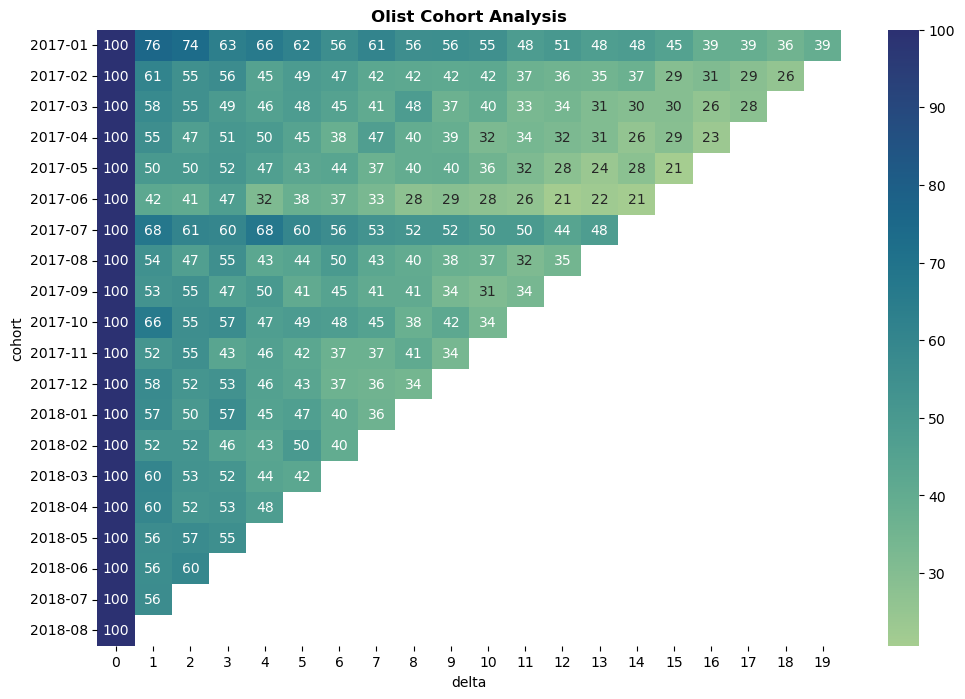

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    cohort_pivot, 
    cmap='crest', 
    annot=True, 
    fmt='.0f')
plt.title("Olist Cohort Analysis", fontweight='bold');

###  9. Que déduire de cette visualisation ?

Il est intéressant de noter que la 1ère et 7ème cohortes ont été relativement plus fidèles à Olist que les autres. Ce sont les seules avec un taux de participation 6 mois après la première vente strictement supérieur à 50%.

Il appartient désormais aux équipes d'Olist (Marketing, Sales) de comprendre pourquoi ces cohortes ont un taux d'attrition nettement plus faible que les autres.

<br><br>